Using device: cpu
Loaded RealESRGAN weights from weights\RealESRGAN_x4plus.pth
Found 17111 images in 'data\SoccerNetResults\crops\imgs'. Starting super resolution...
Processed 10 / 17111 images...
Processed 20 / 17111 images...
Processed 30 / 17111 images...
Processed 40 / 17111 images...
Processed 50 / 17111 images...
Processed 60 / 17111 images...
Processed 70 / 17111 images...
Processed 80 / 17111 images...
Processed 90 / 17111 images...
Processed 100 / 17111 images...
Processed 110 / 17111 images...
Processed 120 / 17111 images...
Processed 130 / 17111 images...
Processed 140 / 17111 images...
Processed 150 / 17111 images...
Processed 160 / 17111 images...
Processed 170 / 17111 images...
Processed 180 / 17111 images...
Processed 190 / 17111 images...
Processed 200 / 17111 images...
Processed 210 / 17111 images...
Processed 220 / 17111 images...
Processed 230 / 17111 images...
Processed 240 / 17111 images...
Processed 250 / 17111 images...
Processed 260 / 17111 images...
Processed 2

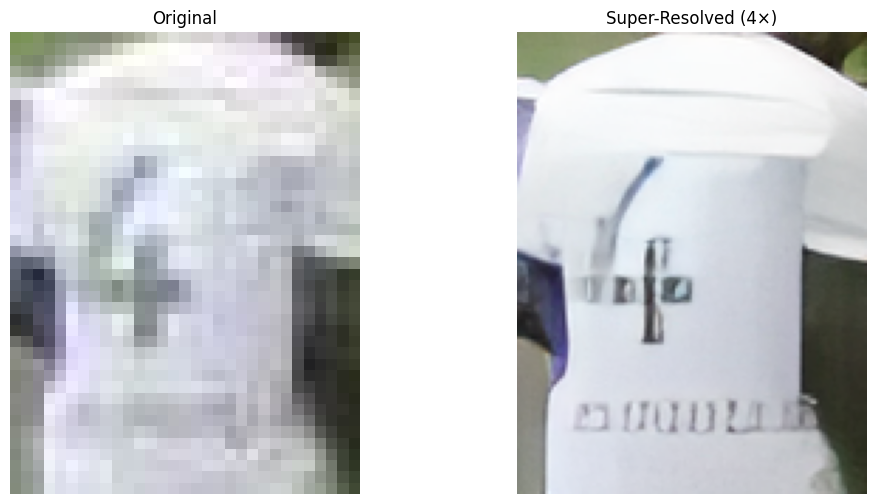

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# If you installed Real-ESRGAN from https://github.com/xinntao/Real-ESRGAN:
# pip install git+https://github.com/xinntao/Real-ESRGAN.git
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

%matplotlib inline


# Path to RealESRGAN weights
model_path = os.path.join('weights', 'RealESRGAN_x4plus.pth')
# Input folder with cropped images from SoccerNet
input_folder = os.path.join('data', 'SoccerNetResults', 'crops', 'imgs')
# Output folder for super-resolved results
output_folder = 'results_sr'

os.makedirs(output_folder, exist_ok=True)

# Choose device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RealESRGAN_x4plus is a 4× upscaling model based on RRDBNet
model = RRDBNet(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_block=23,
    num_grow_ch=32,
    scale=4
)

# Create the RealESRGANer (upsampler) object
# - tile=0 processes the entire image at once; if you get OOM, set tile=128 or 256
# - half=True uses half-precision on GPU for speed; set half=False if on CPU
upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=(device.type == 'cuda')
)

print(f"Using device: {device}")
if not os.path.exists(model_path):
    print(f"Warning: Model weights not found at {model_path}")
else:
    print(f"Loaded RealESRGAN weights from {model_path}")

valid_exts = ('.jpg', '.jpeg', '.png')
input_files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_exts)]
input_files.sort()

if not input_files:
    print(f"No images found in '{input_folder}'. Please add images and re-run.")
else:
    print(f"Found {len(input_files)} images in '{input_folder}'. Starting super resolution...")

for idx, filename in enumerate(input_files):
    img_path = os.path.join(input_folder, filename)
    # Load image with PIL
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img)

    # Perform super resolution
    try:
        with torch.no_grad():
            sr_img_np, _ = upsampler.enhance(img_np, outscale=4)
    except RuntimeError as e:
        print(f"Error processing {filename}: {e}")
        continue

    # Convert result to PIL image
    sr_img = Image.fromarray(sr_img_np)
    # Save to output folder
    out_path = os.path.join(output_folder, f"SR_{filename}")
    sr_img.save(out_path)

    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1} / {len(input_files)} images...")

print("\nSuper resolution complete! Check the 'results_sr' folder for outputs.")


# Visualize a sample
if input_files:
    sample_file = input_files[0]  # Show the first file as an example
    sample_path = os.path.join(input_folder, sample_file)
    sample_img = Image.open(sample_path).convert('RGB')
    sample_img_np = np.array(sample_img)

    with torch.no_grad():
        sr_sample_np, _ = upsampler.enhance(sample_img_np, outscale=4)

    sr_sample_img = Image.fromarray(sr_sample_np)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(sample_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Super-Resolved (4×)")
    plt.imshow(sr_sample_img)
    plt.axis('off')

    plt.show()


In [2]:
import os
import sys
import torch
import numpy as np
import random
import zipfile
import glob
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image

# If you installed Real-ESRGAN from https://github.com/xinntao/Real-ESRGAN:
# pip install git+https://github.com/xinntao/Real-ESRGAN.git
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

%matplotlib inline

# ----------------------------------------------------------------------
# 1. Configure Paths and Model
# ----------------------------------------------------------------------
# Folder structure is assumed as:
# test/
#   images/
#     8/
#       ...some images...
#     9/
#       ...some images...
#     ...
#
# The RealESRGAN weights (RealESRGAN_x4plus.pth) are in the "weights" folder.
# The script will output results into "results_sr" while preserving subfolder structure.

model_path = os.path.join('weights', 'RealESRGAN_x4plus.pth')
input_folder = os.path.join('test', 'images')  # Contains subfolders like 8/, 9/, etc.
output_folder = 'results_sr'

os.makedirs(output_folder, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------------------
# 2. Create the RealESRGAN Model
# ----------------------------------------------------------------------
model = RRDBNet(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_block=23,
    num_grow_ch=32,
    scale=4
)

upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=(device.type == 'cuda')
)

print(f"Using device: {device}")
if not os.path.exists(model_path):
    print(f"Warning: Model weights not found at {model_path}")
else:
    print(f"Loaded RealESRGAN weights from {model_path}")

# ----------------------------------------------------------------------
# 3. Define Data Augmentation Function
# ----------------------------------------------------------------------
def augment_image(img):
    """
    Apply random augmentations to a PIL image:
      - Random horizontal flip (p=0.5)
      - Random rotation between -15 and 15 degrees
      - Random crop (80%-100% of original size), then resize back
      - Random brightness and contrast adjustment
    """
    # Random horizontal flip
    if random.random() < 0.5:
        img = TF.hflip(img)
    
    # Random rotation
    angle = random.uniform(-15, 15)
    img = TF.rotate(img, angle)
    
    # Random crop: crop a random portion (80%-100%) of the image, then resize
    width, height = img.size
    crop_scale = random.uniform(0.8, 1.0)
    new_width = int(width * crop_scale)
    new_height = int(height * crop_scale)
    if new_width < width and new_height < height:
        left = random.randint(0, width - new_width)
        top = random.randint(0, height - new_height)
        img = img.crop((left, top, left + new_width, top + new_height))
        img = img.resize((width, height), Image.BICUBIC)
    
    # Random brightness
    brightness_factor = random.uniform(0.8, 1.2)
    img = TF.adjust_brightness(img, brightness_factor)
    
    # Random contrast
    contrast_factor = random.uniform(0.8, 1.2)
    img = TF.adjust_contrast(img, contrast_factor)
    
    return img

# ----------------------------------------------------------------------
# 4. Recursively Gather All Images, Process, and Preserve Folder Structure
# ----------------------------------------------------------------------
valid_exts = ('.jpg', '.jpeg', '.png')
image_paths = []

# Walk through all subdirectories in "test/images"
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(valid_exts):
            image_paths.append(os.path.join(root, file))

image_paths.sort()
if not image_paths:
    print(f"No images found in '{input_folder}'. Please add images and re-run.")
else:
    print(f"Found {len(image_paths)} images in '{input_folder}'. Starting super resolution with augmentation...")

for idx, img_path in enumerate(image_paths):
    # Load and augment
    img = Image.open(img_path).convert('RGB')
    img_aug = augment_image(img)
    
    # Convert to NumPy array
    img_np = np.array(img_aug)
    
    # Super-resolve
    try:
        with torch.no_grad():
            sr_img_np, _ = upsampler.enhance(img_np, outscale=4)
    except RuntimeError as e:
        print(f"Error processing {img_path}: {e}")
        continue
    
    sr_img = Image.fromarray(sr_img_np)
    
    # Preserve subfolder structure under "results_sr"
    # e.g., if img_path = "test/images/8/img001.jpg"
    # rel_path = "8/img001.jpg"
    rel_path = os.path.relpath(img_path, input_folder)
    rel_dir = os.path.dirname(rel_path)
    
    # Make the corresponding output directory
    out_dir = os.path.join(output_folder, rel_dir)
    os.makedirs(out_dir, exist_ok=True)
    
    # Save with a prefix indicating augmentation
    filename = os.path.basename(img_path)
    out_path = os.path.join(out_dir, f"SR_aug_{filename}")
    sr_img.save(out_path)
    
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1} / {len(image_paths)} images...")

print("\nSuper resolution with augmentation complete! Check the 'results_sr' folder for outputs.")

# ----------------------------------------------------------------------
# 5. (Optional) Visualize a Sample
# ----------------------------------------------------------------------
# If you want to preview one random image from your dataset:
if image_paths:
    sample_file = random.choice(image_paths)
    sample_img = Image.open(sample_file).convert('RGB')
    sample_img_aug = augment_image(sample_img)
    sample_img_np = np.array(sample_img_aug)
    
    with torch.no_grad():
        sr_sample_np, _ = upsampler.enhance(sample_img_np, outscale=4)
    
    sr_sample_img = Image.fromarray(sr_sample_np)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Input")
    plt.imshow(sample_img_aug)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Super-Resolved (4×)")
    plt.imshow(sr_sample_img)
    plt.axis('off')
    
    plt.show()


Using device: cpu
Loaded RealESRGAN weights from weights\RealESRGAN_x4plus.pth
Found 564547 images in 'test\images'. Starting super resolution with augmentation...
Processed 10 / 564547 images...
Processed 20 / 564547 images...
Processed 30 / 564547 images...
Processed 40 / 564547 images...
Processed 50 / 564547 images...
Processed 60 / 564547 images...
Processed 70 / 564547 images...
Processed 80 / 564547 images...
Processed 90 / 564547 images...
Processed 100 / 564547 images...
Processed 110 / 564547 images...
Processed 120 / 564547 images...
Processed 130 / 564547 images...
Processed 140 / 564547 images...
Processed 150 / 564547 images...
Processed 160 / 564547 images...
Processed 170 / 564547 images...
Processed 180 / 564547 images...
Processed 190 / 564547 images...
Processed 200 / 564547 images...
Processed 210 / 564547 images...
Processed 220 / 564547 images...
Processed 230 / 564547 images...
Processed 240 / 564547 images...
Processed 250 / 564547 images...
Processed 260 / 5645

KeyboardInterrupt: 